In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [7]:
import logging
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    ONE_AND_HALF_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)
from src.parameters import STATE_COLORS, TRANSITION_TO_CATEGORY, SAMPLING_FREQUENCY

set_figure_defaults()

In [8]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var
from src.sorted_spikes_simulation import make_hover_continuous_fragmented_replay

(
    time,
    linear_distance,
    sampling_frequency,
    spikes,
    place_fields,
) = make_simulated_run_data()

movement_var = estimate_movement_var(linear_distance, sampling_frequency)
replay_time, test_spikes = make_hover_continuous_fragmented_replay()
replay_time *= SAMPLING_FREQUENCY

In [10]:
from tqdm.autonotebook import tqdm

discrete_transition_diag = [
    1 / 3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.99,
    0.999,
    0.9999,
    0.99999,
    0.999999,
    0.9999999,
    0.99999999,
    0.9999999999,
    1.0,
]
results = []

for diag in tqdm(discrete_transition_diag):

    classifier = SortedSpikesClassifier(
        movement_var=movement_var,
        replay_speed=120,
        spike_model_penalty=0.5,
        place_bin_size=np.sqrt(movement_var),
        discrete_transition_diag=diag,
    )
    classifier.fit(linear_distance, spikes)

    results.append(
        classifier.predict(test_spikes, time=replay_time).assign_coords(
            state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
        )
    )

In [15]:
def plot_probabilities(results, ax=None):
    if ax is None:
        ax = plt.gca()
    probabilities = results.acausal_posterior.sum("position").values

    for probability, state in zip(probabilities.T, results.state.values):
        ax.plot(
            results.time,
            probability,
            linewidth=2,
            label=state,
            color=STATE_COLORS[state],
        )
    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)
    ax.set_yticks([0, 1])
    ax.set_ylim([0, 1.05])
    sns.despine()

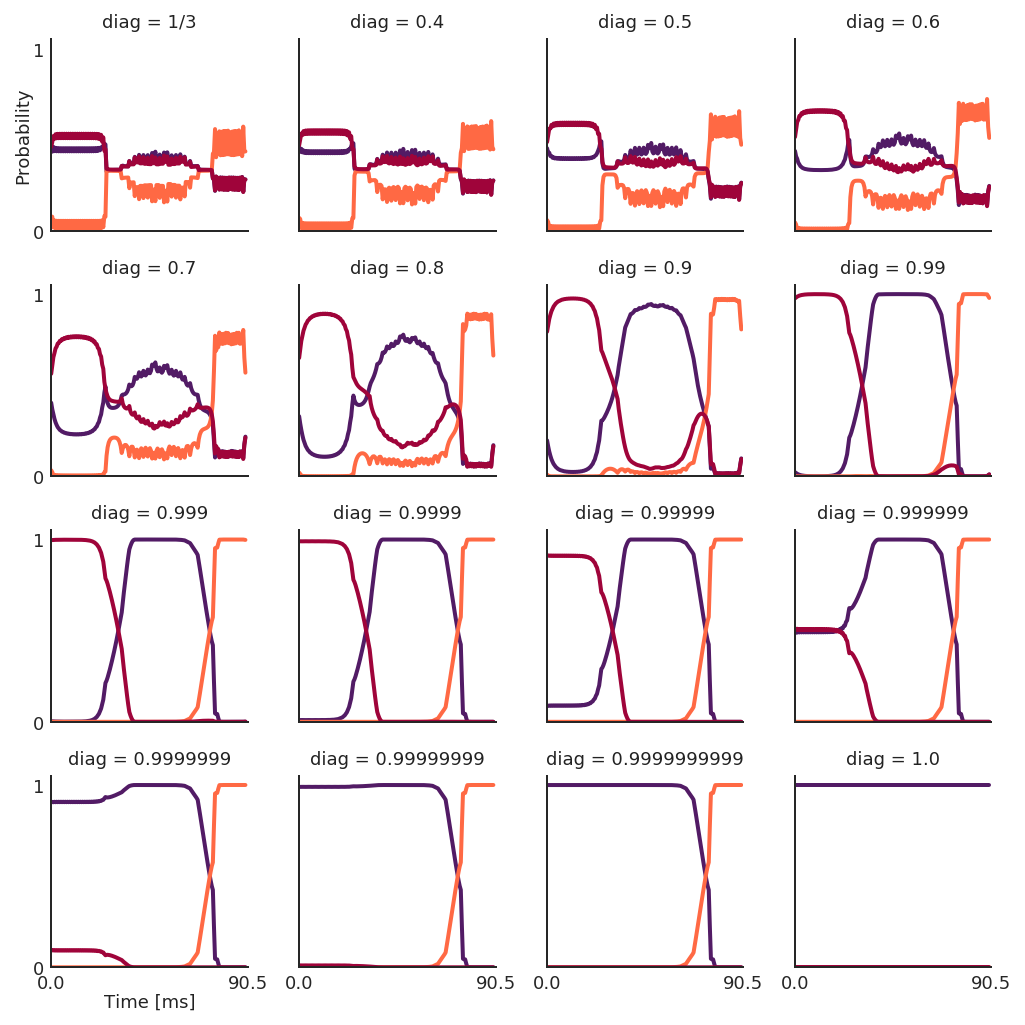

In [29]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(TWO_COLUMN, TWO_COLUMN),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

for ax, diag, result in zip(axes.flat, discrete_transition_diag, results):
    plot_probabilities(result, ax=ax)
    if np.isclose(diag, 1 / 3):
        ax.set_title("diag = 1/3", fontsize=9)
    else:
        ax.set_title(f"diag = {diag}", fontsize=9)

axes[0, 0].set_ylabel("Probability")
axes[-1, 0].set_xlabel("Time [ms]")
save_figure("figure1_supplemental1_changing_discrete_diagonal")

In [51]:
def plot_posterior(
    classifier,
    results,
    linear_distance,
    ax=None,
    cbar_orientation="vertical",
    cbar_aspect=50,
):
    if ax is None:
        ax = plt.gca()

    posterior = results.acausal_posterior.sum("state")
    posterior.plot(
        x="time",
        y="position",
        vmin=0.0,
        robust=True,
        rasterized=True,
        ax=ax,
        add_colorbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    xlim = results.time.min(), results.time.max() + 1
    ax.set_xticks(xlim)
    ax.set_xlim(xlim)

    ylim = linear_distance.min(), linear_distance.max()
    ax.set_yticks(ylim)
    ax.set_ylim(ylim)

Text(0.5, 0, 'Time [ms]')

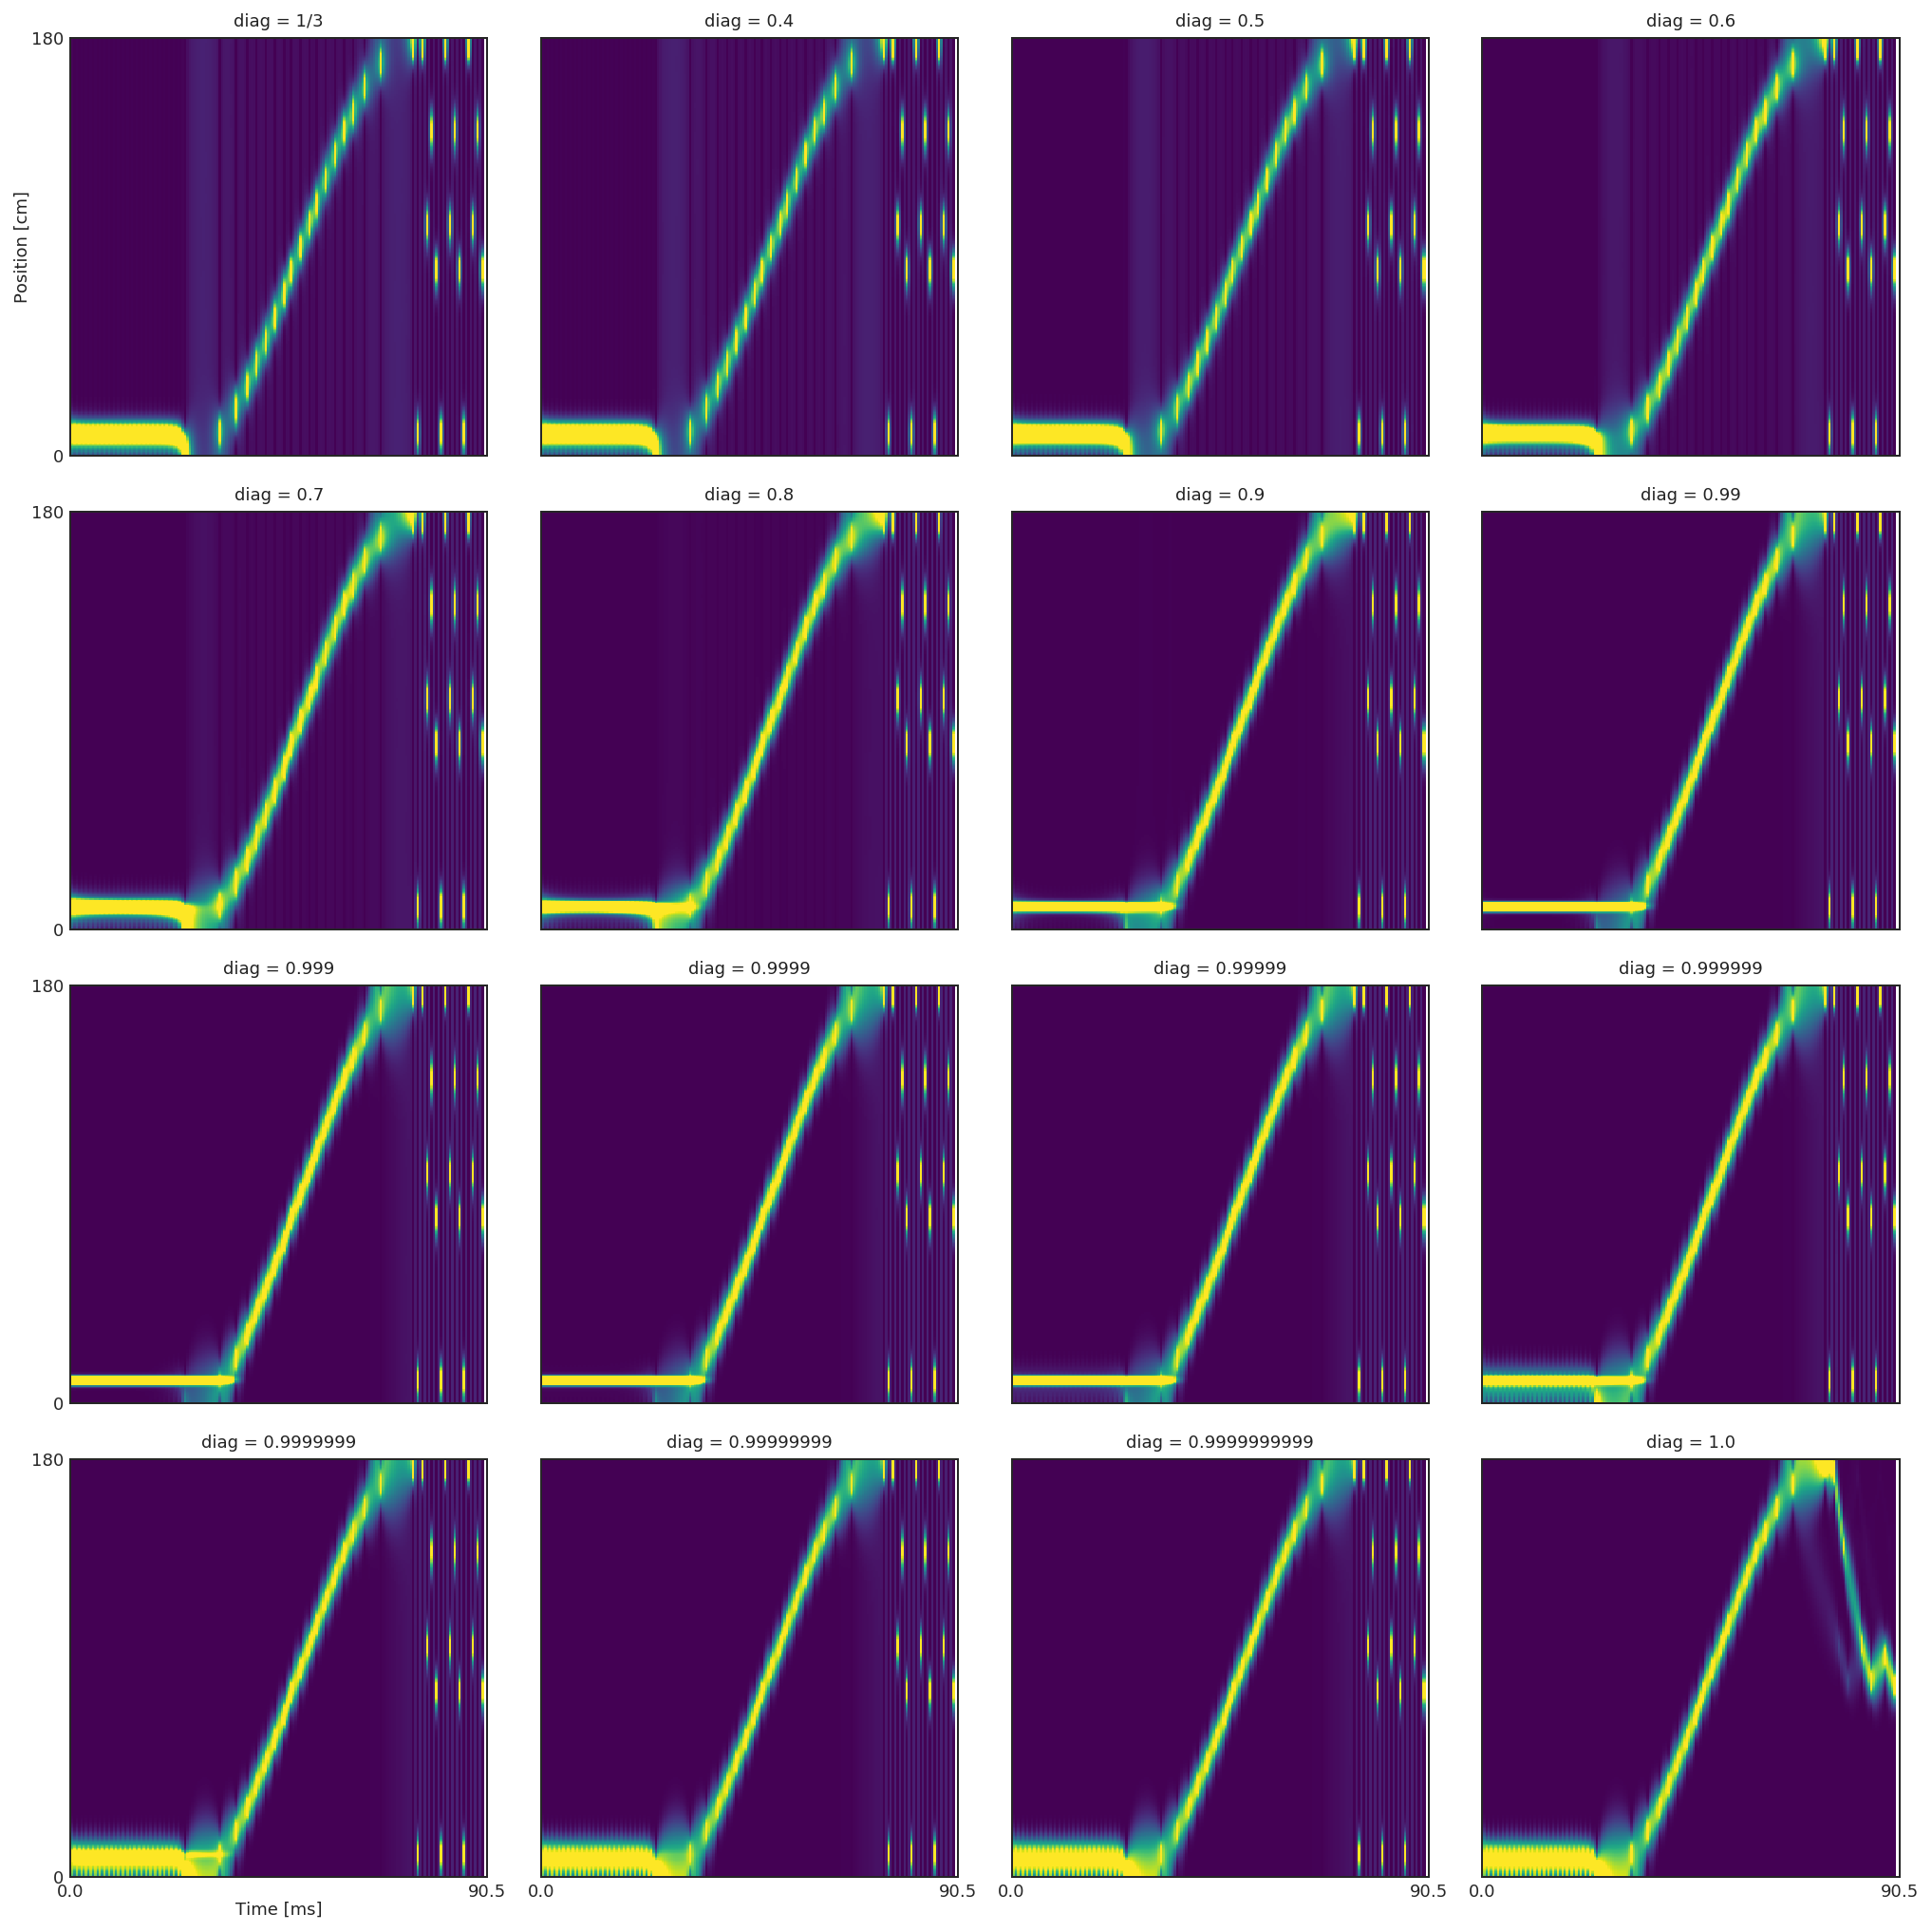

In [58]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=(TWO_COLUMN, TWO_COLUMN),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

for ax, diag, result in zip(axes.flat, discrete_transition_diag, results):
    plot_posterior(
        classifier,
        result,
        linear_distance,
        ax=ax,
        cbar_orientation="vertical",
        cbar_aspect=50,
    )
    if np.isclose(diag, 1 / 3):
        ax.set_title("diag = 1/3", fontsize=9)
    else:
        ax.set_title(f"diag = {diag}", fontsize=9)

axes[0, 0].set_ylabel("Position [cm]")
axes[-1, 0].set_xlabel("Time [ms]")
save_figure("figure1_supplemental1_changing_discrete_diagonal_posterior")

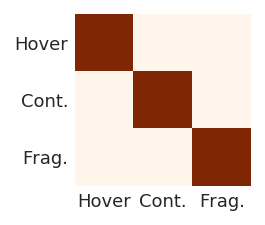

In [66]:
import pandas as pd


discrete_state_transition = np.identity(3)

state_names = ["Hover", "Cont.", "Frag."]
fig, ax = plt.subplots(figsize=(ONE_COLUMN * 0.45, ONE_COLUMN * 0.45))
m = sns.heatmap(
    pd.DataFrame(discrete_state_transition, index=state_names, columns=state_names),
    annot=False,
    cmap="Oranges",
    ax=ax,
    cbar=False,
    annot_kws=dict(fontsize=9),
    cbar_kws=dict(label="Probability", ticks=[0, 1], orientation="horizontal"),
    vmin=0.0,
    vmax=1.0,
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
save_figure("figure1_supplemental1_discrete_transition_identity")

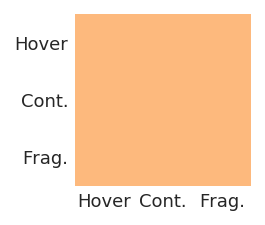

In [67]:
import pandas as pd


discrete_state_transition = np.ones((3, 3)) / 3

state_names = ["Hover", "Cont.", "Frag."]
fig, ax = plt.subplots(figsize=(ONE_COLUMN * 0.45, ONE_COLUMN * 0.45))
m = sns.heatmap(
    pd.DataFrame(discrete_state_transition, index=state_names, columns=state_names),
    annot=False,
    cmap="Oranges",
    ax=ax,
    cbar=False,
    annot_kws=dict(fontsize=9),
    cbar_kws=dict(label="Probability", ticks=[0, 1], orientation="horizontal"),
    vmin=0.0,
    vmax=1.0,
)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
save_figure("figure1_supplemental1_discrete_transition_equal")